# Slider Experiment

In [1]:
import csv
import glob
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import pingouin as pg
import scikit_posthocs as ph
import scipy.stats as stats
import seaborn as sns

from collections import OrderedDict
from tabulate import tabulate

sns.set_context("notebook")
sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['patch.linewidth'] = 0.0

palette = sns.color_palette("magma", 4)

/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Log parsing code

In [2]:
SHAPE_MOVE_THRESHOLD = 25

class Log:
    def __init__(self, PID, gesture, task, target, block, startTime, endTime, frames=None):
        self.PID = PID
        self.gesture = gesture
        self.task = task
        self.target = target
        self.block = block
        self.startTime = startTime
        self.endTime = endTime
        if frames is None:
            self.frames = []
        else:
            self.frames = frames

    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)

class Frame:
    def __init__(self, activity, state, cursor_X, cursor_y, slider_position_X, slider_value, message=""):
        self.activity = activity
        self.state = state
        self.cursor_X = cursor_X
        self.cursor_y = cursor_y
        self.slider_position_X = slider_position_X
        self.slider_value = slider_value
        self.message = message

    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)

def extract_data(jsonData):
    """
    Parse json into an instance of the Log class.
    """
    frames = []

    for f in jsonData["frames"]:
        frames.append(Frame(f["activity"], f["state"], f["cursor_X"], f["cursor_y"], f["slider_position_X"], f["slider_value"], f["message"] if "message" in f else ""))

    return Log(jsonData["PID"], jsonData["gesture"], jsonData["task"], jsonData["target"], jsonData["block"], jsonData["startTime"], jsonData["endTime"], frames)

def block_success(data: Log):
    """
    Determine task success based on the final slider value.
    """
    frame = data.frames[-1]
    
    return ((frame.slider_value == data.target) or (data.task == "shapeMove" and abs(frame.slider_value - data.target) <= SHAPE_MOVE_THRESHOLD))

def time(data: Log):
    """
    Calculate overall task time and time taken for first land on a target.
    """
    
    # Total number of frames
    total_frames = len(data.frames)
    
    # Running count of frames
    frame_count = 0
    
    # Task start and end time
    task_start_frame = 0
    time_start = data.startTime
    time_end = data.endTime
    
    time = time_end - time_start
    time_calculated = True
    
    # Time where the user first hits the target
    time_hit = -1
    time_hit_calculated = False
    
    # Running count of task number - needed since frames contains all previous tasks
    current_block_num = 0
    
    for frame in data.frames:
        frame_count += 1
        
        # Log file for task N also includes all data for tasks 0 to N-1, so we need to skip these
        if current_block_num < data.block:
            if frame.activity.startswith("BlockCompleted"):
                current_block_num = int(frame.message.split(" ")[1]) + 1
            
            continue
        
        # Initialise the frame index where this task started
        if task_start_frame == -1:
            task_start_frame = frame_count
            total_frames -= frame_count
            frame_count = 0
        
        # Calculate the ratio for the current frame index
        ratio = frame_count / float(total_frames)
        
        #if not time_calculated:
        #    time_start = data.startTime + ((time_end - time_start) * ratio)
        #    time = time_end - time_start
        #    time_calculated = True
        #    
        #    time_hit = time # Set this now as a fallback
        
        # Check if the slider has hit the target for the first time
        if time_calculated and ((frame.slider_value == data.target) or (data.task == "shapeMove" and abs(frame.slider_value - data.target) <= SHAPE_MOVE_THRESHOLD)):
            time_hit = ratio * (time_end - time_start)    
            time_hit_calculated = True
        
        if time_calculated and time_hit_calculated:
            break

    if time_hit_calculated:
        return (time, time_hit)
    else:
        return (time, -1)

def overshoots(data: Log):
    """
    Count the number of target overshoots. There are two types of overshoot: going above and
    going below the target value. These are counted when the selected slider value moves over
    the target in a sequence. Might be some bugs with this, e.g., if the slider never perfectly
    sets on the target.
    """
    overList = []
    overCount = 0
    
    # Has crossed to a higher value
    crossed_above = False
    
    # Has crossed to a lower value
    crossed_below = False
    
    current_block_num = 0
    
    for frame in data.frames:
        # Log file for task N also includes all data for tasks 0 to N-1, so we need to skip these
        if current_block_num < data.block:
            if frame.activity.startswith("BlockCompleted"):
                current_block_num = int(frame.message.split(" ")[1]) + 1
            
            continue
        
        # Now we can start counting
        if frame.slider_value > data.target:
            if not crossed_above:
                crossed_above = True
                crossed_below = False
                
                overCount += 1
                
            overList.append(frame.slider_value)
        else:
            crossed_above = False
            
            if frame.slider_value == data.target:
                crossed_below = True # Not true, but we need to know when we fall off the other side
            else:
                if crossed_below:
                    crossed_below = False
                    
                    overCount += 1
                
                overList.append(frame.slider_value)
            
    return (overList, overCount)

def alphabet_target(letter):
    """
    Calculates the target coordinate for the given letter.
    """
    letters = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]
    target_width = 52.30769230769231
    target_offset = letters.index(letter)
    
    return 600.0 + (target_width / 2.0) + (target_width * target_offset)

def digit_target(digit):
    """
    Calculates the target coordinator for the given digit.
    """
    target_width = 136.0
    
    return 600.0 + (target_width / 2.0) + (target_width * digit)

def target_distance(data: Log):
    """
    Calculates the distance in pixels between the target and the final cursor position.
    """
    if len(data.frames) == 0:
        return -1
    
    frame = data.frames[-1]
    
    if data.task == "shapeMove":
        return frame.slider_value - data.target
    elif data.task == "alphaSelector":
        return frame.slider_position_X - alphabet_target(data.target)
    elif data.task == "digitSelector":
        return frame.slider_position_X - digit_target(data.target)
    else:
        return -1

def count_engagements(data: Log):
    """
    Calculates the number of times the user 'engaged' the slider.
    """
    engaged = False
    count = 0
    
    current_block_num = 0
    
    for frame in data.frames:
        # Log file for task N also includes all data for tasks 0 to N-1, so we need to skip these
        if current_block_num < data.block:
            if frame.activity.startswith("BlockCompleted"):
                current_block_num = int(frame.message.split(" ")[1]) + 1
            
            continue
        
        # Now we can start counting
        if frame.message in ["Transitioning from states NoPinchDetected to PinchDetected", "Transitioning from states NoDwellDetected to DwellDetected"]:
            count += 1
    
    return count

def slider_loc(data: Log):
    """
    Returns the final slider coordinate.
    """
    return ((data.frames[-1].slider_position_X))

# Import log data

In [3]:
columnNames = ["P", "B", "Condition", "Task", "Target", "Selected", "Time", "Time to Target", "Success",
               "Activations", "Overshoots", "Overshoot_Values", "Location", "ErrorDistance", "AbsErrorDistance"]
data = pd.DataFrame(columns = columnNames)

files = glob.glob("../Logs/*/*/*/*.json")
#files = glob.glob("/Users/kieranwaugh/OneDrive - University of Glasgow/Evaluation_of_Touchless_Scrolling_Interactions/Logs/*/*/*/*.json")
log: Log

# Log files for individual participants can be cached to save regenerating everything
cache_logs = glob.glob("Cache/*.tsv")
use_cache = True

if True:
    for file in files:
        with open(file) as json_file:
            pid = file.split("/")[-4]
            condition = file.split("/")[-2]
            task = file.split("/")[-3]
            
            if use_cache and "Cache/P{}.tsv".format(pid,) in cache_logs:
                continue

            if pid not in ["-1", "1", "2", "3", "4"]:
                log = extract_data(json.load(json_file))

                (task_time, time_to_hit) = time(log)
                success = block_success(log)
                (overshootHits, overshootCount) = overshoots(log)
                activations = count_engagements(log)
                sliderPos = slider_loc(log)
                errorDistance = target_distance(log)

                log_data = pd.DataFrame(columns = columnNames, data =
                                        [[pid, log.block, condition, task, log.target, log.frames[-1].slider_value,
                                          task_time, time_to_hit, success, activations, overshootCount, set(overshootHits),
                                          sliderPos, errorDistance, abs(errorDistance)]])
                data = data.append(log_data)
    
    # Now read in the cached results
    if use_cache:
        for file in cache_logs:
            data_cached = pd.read_csv(file, sep="\t")
            data = pd.concat([data, data_cached], ignore_index=True)
    
    # Drop task time outliers
    data_filtered = data[data['Time'] <= 30000]
    data_filtered = data_filtered[data_filtered['Time'] > 10]
    
    # Drop tasks where the target was the first cursor point
    data_filtered = data_filtered[data_filtered['Target'] != "A"]
    data_filtered = data_filtered[data_filtered['Target'] != 1]
    
    # Drop tasks with distance outliers
    data_filtered = data_filtered[data_filtered['AbsErrorDistance'] <= 150]

    n_new = len(data)
    n_new_filtered = len(data_filtered)
    print("Read {} new results and kept {} after filtering".format(n_new, n_new_filtered,))
    
    # Write all data to a single file
    data_filtered.to_csv("all_data.tsv", sep="\t")
else:
    data_filtered = pd.read_csv("all_data.tsv", sep="\t")
    
    print("Read {} results".format(len(data_filtered)))
    
# Write individual participant data
for p in data_filtered.P.unique():
    df_p = data_filtered[data_filtered.P == p]
    df_p.to_csv("Cache/P{}.tsv".format(p,), sep="\t")

# Force category types and re-order labels
data_filtered["Condition"] = data_filtered["Condition"].astype('category')
data_filtered["Task"] = data_filtered["Task"].astype('category')
data_filtered["Condition"] = data_filtered["Condition"].cat.reorder_categories(["baseline", "Dwell", "pinchOnCircle", "pinchAny"])
data_filtered["Task"] = data_filtered["Task"].cat.reorder_categories(["alphaSelector", "digitSelector", "shapeMove"])

# Force metrics to numeric type
data_filtered["Time"] = pd.to_numeric(data_filtered["Time"])
data_filtered["Time to Target"] = pd.to_numeric(data_filtered["Time to Target"])
data_filtered["ErrorDistance"] = pd.to_numeric(data_filtered["ErrorDistance"])
data_filtered["AbsErrorDistance"] = pd.to_numeric(data_filtered["AbsErrorDistance"])
data_filtered["Success"] = pd.to_numeric(data_filtered["Success"])
data_filtered["Overshoots"] = pd.to_numeric(data_filtered["Overshoots"])
data_filtered["Activations"] = pd.to_numeric(data_filtered["Activations"])

# Calculate aggregate values across repeated measures
data_agg = data_filtered.groupby(["P", "Condition", "Task"], as_index=False)[["Time", "Time to Target", "ErrorDistance",
                                                                              "AbsErrorDistance", "Success", "Overshoots", "Activations"]].mean()


Read 2016 new results and kept 2016 after filtering


# Summary

In [4]:
print("Read data from {} participants".format(len(data_filtered.P.unique()),))

data_agg.agg({'Time': ['mean', 'std', 'min', 'max'],
                   'Time to Target': ['mean', 'std', 'min', 'max'],
                   'Success': ['mean', 'std'],
                   'Overshoots': ['mean', 'std', 'min', 'max'],
                   'Activations': ['mean', 'std', 'min', 'max'],
                   'ErrorDistance': ['mean', 'std', 'min', 'max'],
                   'AbsErrorDistance': ['mean', 'std', 'min', 'max']})

Read data from 15 participants


,Time,Time to Target,Success,Overshoots,Activations,ErrorDistance,AbsErrorDistance
mean,10222.304152,9257.013960,0.964821,1.077237,3.549666,0.972433,10.282888
std,3897.450549,3578.020607,0.077192,0.771976,1.762256,5.859745,5.530025
min,2465.272727,2382.276804,NaN,0.000000,1.083333,-20.728413,2.200000
max,21994.666667,20944.732325,NaN,3.666667,11.428571,17.158518,35.573624


# Exploratory plots

In [5]:
def point_plot(df, dv, iv, n_iv, max_x, xlab="", ylab="", show_grid=False, show_all=True, plot_w=7, plot_h=2, filename=None):
    """
    Creates a point plot showing mean values with 95% confidence intervals.
    
    df: Data frame.
    dv: Column name with the dependent variable measurements.
    iv: Column name with the independent variable values.
    n_iv: Number of levels in the independent variable.
    max_x: Maximum x-axis value.
    show_grid: If True, show a grid in the plot.
    show_all: If True, include a strip plot.
    plot_w: Plot width in inches.
    plot_h: Plot height in inches.
    filename: If given, save to a pdf with this filename.
    """
    plot, axis = plt.subplots(figsize=(plot_w, plot_h))
    
    if show_all:
        sns.stripplot(x=dv, y=iv, hue=iv, data=df, palette=palette, dodge=True, size=6, alpha=0.05, jitter=1.05)
        
    sns.pointplot(x=dv, y=iv, hue=iv, data=df, palette=palette, dodge=.532, join=False, errwidth=1.2, scale=1.5, ci=95)

    # Adjust legend
    handles, labels = axis.get_legend_handles_labels()
    
    for i, label in enumerate(labels):
        if label == "pinchAny":
            labels[i] = "Pinch Anywhere"
        elif label == "pinchOnCircle":
            labels[i] = "Pinch"
        elif label == "baseline":
            labels[i] = "AirTouch"
        elif label == "alphaSelector":
            labels[i] = "Alphabet"
        elif label == "digitSelector":
            labels[i] = "Digits"
        elif label == "shapeMove":
            labels[i] = "Scale"
    
    axis.legend(handles[0:n_iv], labels[0:n_iv], handletextpad=0, columnspacing=1, loc="lower center", ncol=4, frameon=False, bbox_to_anchor=(0.493, 1.0))

    # Adjust axes
    axis.set_ylabel(ylab)
    axis.set_xlabel(xlab)
    axis.set(xlim=(0, max_x))
    axis.yaxis.set_visible(False)
    axis.grid(show_grid)
    
    if show_all:
        axis.margins(x=0.05, y=0.05)

    # Show and save
    plt.show()
    
    if filename is not None:
        plot.savefig(filename, bbox_inches='tight')
        
    return (plot, axis)
        
def point_plot_2f(df, dv, iv1, iv2, n_iv1, n_iv2, xlim=(0, 1), xlab="", ylab="", v_annotate=None, show_grid=False, show_all=True, plot_w=7, plot_h=5, filename=None):
    """
    Creates a two-factor point plot showing mean values with 95% confidence intervals.
    
    df: Data frame.
    dv: Column name with the dependent variable measurements.
    iv1: Column name with the first independent variable values.
    iv2: Column name with the second independent variable values.
    n_iv1: Number of levels in the first independent variable.
    n_iv2: Number of levels in the second independent variable.
    max_x: Maximum x-axis value.
    show_grid: If True, show a grid in the plot.
    show_all: If True, include a strip plot.
    plot_w: Plot width in inches.
    plot_h: Plot height in inches.
    filename: If given, save to a pdf with this filename.
    """
    
    plot, axis = plt.subplots(figsize=(plot_w, plot_h))

    if v_annotate is not None:
        plt.axvline(v_annotate, 0, 1, dashes=[3, 3], alpha=0.5, color="grey")
    
    if show_all:
        sns.stripplot(x=dv, y=iv1, hue=iv2, data=df, palette=palette, dodge=True, size=6, alpha=0.05, jitter=0.3)

    sns.pointplot(x=dv, y=iv1, hue=iv2, data=df, palette=palette, dodge=.532, join=False, errwidth=1.2, scale=1.5, ci=95)

    # Adjust legend
    handles, labels = axis.get_legend_handles_labels()
    
    for i, label in enumerate(labels):
        if label == "pinchAny":
            labels[i] = "Pinch Anywhere"
        elif label == "pinchOnCircle":
            labels[i] = "Pinch"
        elif label == "baseline":
            labels[i] = "AirTouch"
        elif label == "alphaSelector":
            labels[i] = "Alphabet"
        elif label == "digitSelector":
            labels[i] = "Digits"
        elif label == "shapeMove":
            labels[i] = "Scale"
    
    axis.legend(handles[0:n_iv1], labels[0:n_iv1], handletextpad=0, columnspacing=1, loc="lower center", ncol=n_iv1, frameon=False, bbox_to_anchor=(0.493, 1.0))

    # Adjust axes
    axis.set_ylabel(ylab)
    axis.set_xlabel(xlab)
    axis.set(xlim=xlim)
    axis.yaxis.set_visible(True)
    axis.grid(show_grid)

    # Show and save
    plt.show()
    
    if filename is not None:
        plot.savefig(filename, bbox_inches='tight')
    
    return (plot, axis)

## Task Time

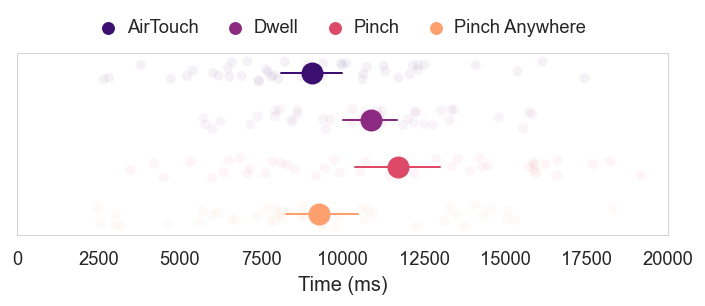

(<Figure size 840x240 with 1 Axes>, <AxesSubplot:xlabel='Time (ms)'>)

In [6]:
point_plot(data_agg, "Time", "Condition", 4, 20000, "Time (ms)", plot_w=7, plot_h=2)

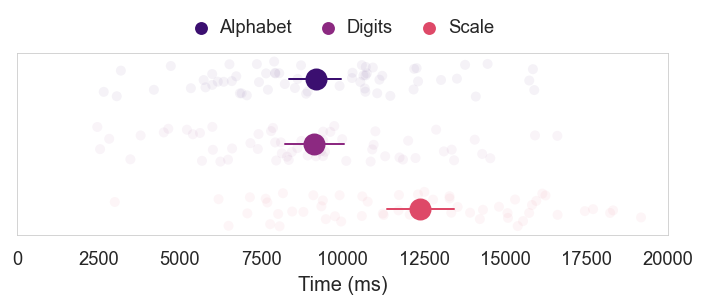

(<Figure size 840x240 with 1 Axes>, <AxesSubplot:xlabel='Time (ms)'>)

In [7]:
point_plot(data_agg, "Time", "Task", 3, 20000, "Time (ms)", plot_w=7, plot_h=2)

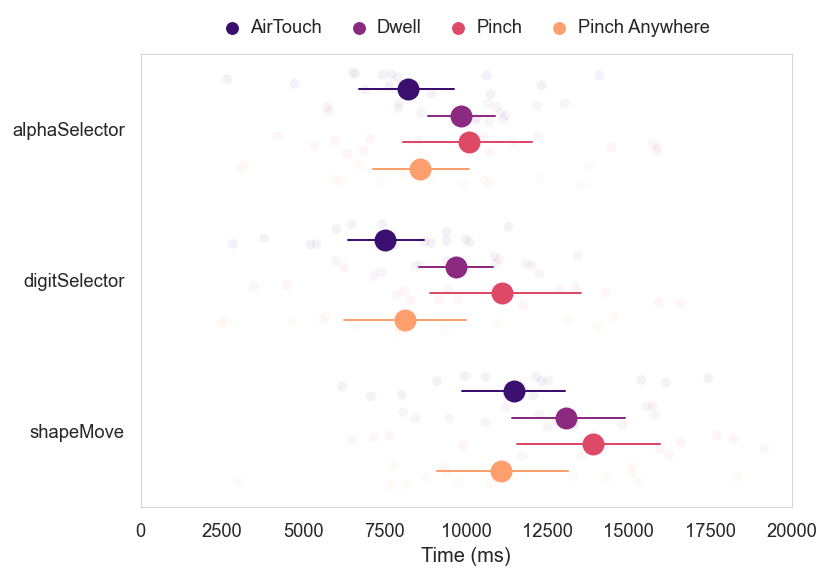

(<Figure size 840x600 with 1 Axes>, <AxesSubplot:xlabel='Time (ms)'>)

In [8]:
point_plot_2f(data_agg, "Time", "Task", "Condition", n_iv1=4, n_iv2=3, xlim=(0, 20000), xlab="Time (ms)", show_grid=False)

## Time to first acquire target

Excludes trials where the target was never directly hit.

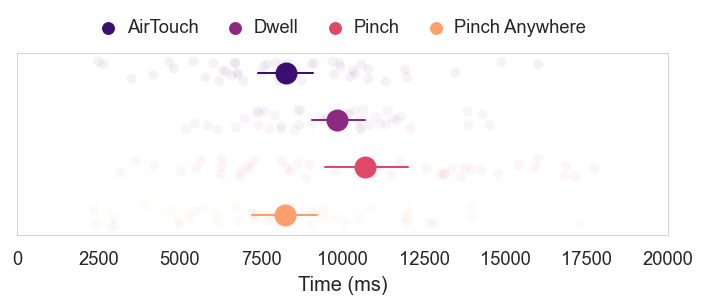

(<Figure size 840x240 with 1 Axes>, <AxesSubplot:xlabel='Time (ms)'>)

In [9]:
point_plot(data_agg, "Time to Target", "Condition", 4, 20000, "Time (ms)", plot_w=7, plot_h=2)

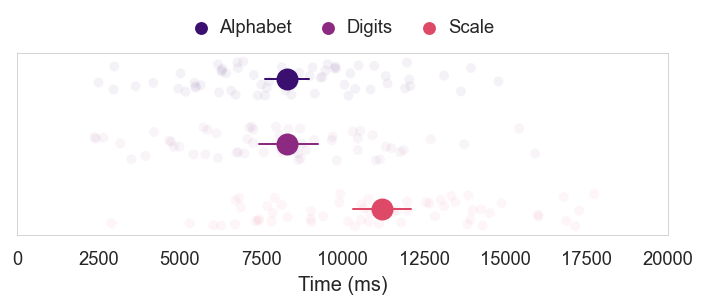

(<Figure size 840x240 with 1 Axes>, <AxesSubplot:xlabel='Time (ms)'>)

In [10]:
point_plot(data_agg, "Time to Target", "Task", 3, 20000, "Time (ms)", plot_w=7, plot_h=2)

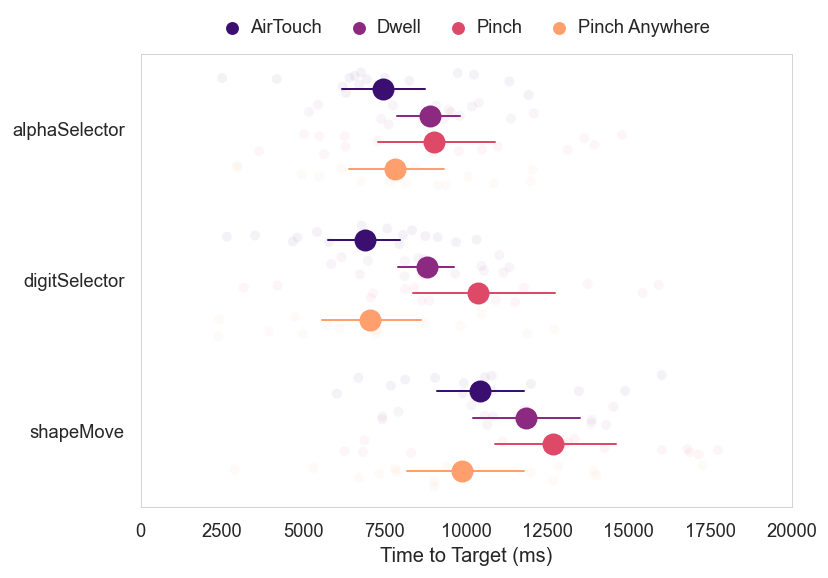

(<Figure size 840x600 with 1 Axes>, <AxesSubplot:xlabel='Time to Target (ms)'>)

In [11]:
point_plot_2f(data_agg, "Time to Target", iv1="Task", iv2="Condition", n_iv1=4, n_iv2=3, xlim=(0, 20000), xlab="Time to Target (ms)", plot_w=7, plot_h=5)

## Distance from target

This is the distance in pixels between the final cursor position and the centre of the target

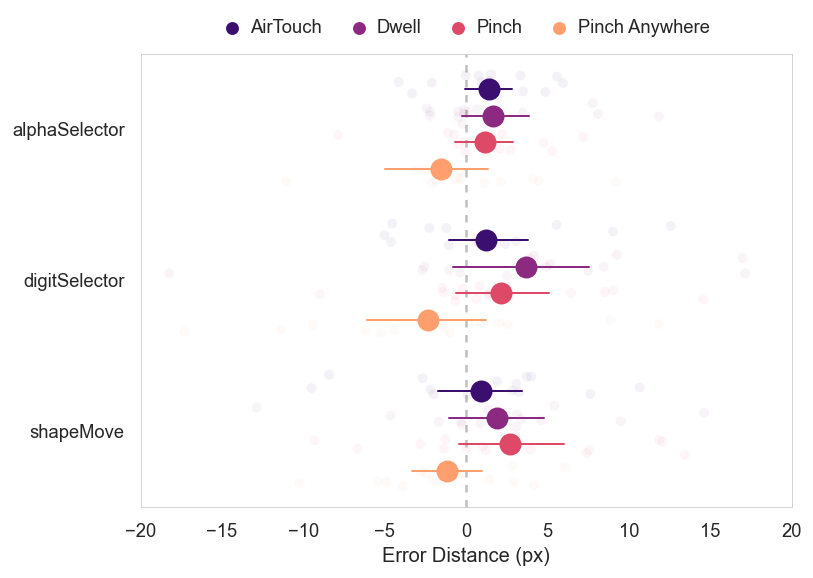

(<Figure size 840x600 with 1 Axes>, <AxesSubplot:xlabel='Error Distance (px)'>)

In [12]:
point_plot_2f(data_agg, "ErrorDistance", "Task", "Condition", n_iv1=4, n_iv2=3, xlim=(-20, 20), xlab="Error Distance (px)", v_annotate=0, show_grid=False)

## Task Success

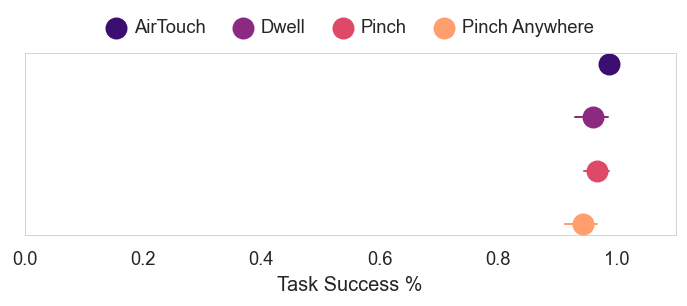

(<Figure size 840x240 with 1 Axes>, <AxesSubplot:xlabel='Task Success %'>)

In [13]:
point_plot(data_agg, "Success", "Condition", 4, 1.1, "Task Success %", plot_w=7, plot_h=2, show_all=False)

## Number of target overshoots

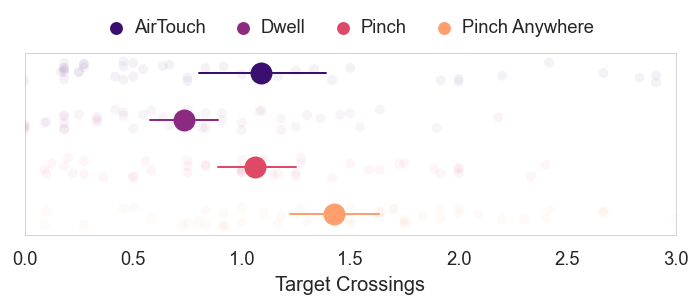

(<Figure size 840x240 with 1 Axes>, <AxesSubplot:xlabel='Target Crossings'>)

In [14]:
point_plot(data_agg, "Overshoots", "Condition", 4, 3, "Target Crossings", plot_w=7, plot_h=2, show_all=True)

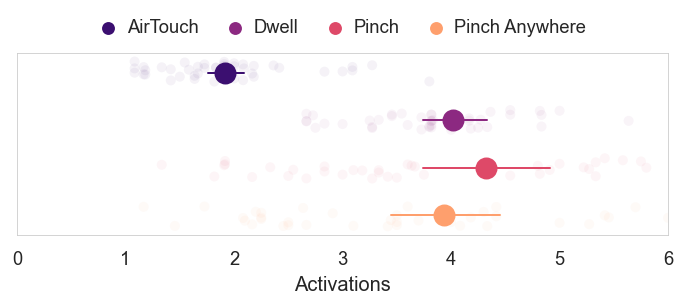

(<Figure size 840x240 with 1 Axes>, <AxesSubplot:xlabel='Activations'>)

In [15]:
point_plot(data_agg, "Activations", "Condition", 4, 6, "Activations", plot_w=7, plot_h=2, show_all=True)

# Analysis

## Task time

In [16]:
s_w = stats.shapiro(data_agg["Time"])

if s_w.pvalue <= 0.05:
    print("Task time data does not come from a normal distribution (p = {:.3f}), perform ART in R instead".format(s_w.pvalue,))
    
    sns.displot(data_agg, x="Time", kind="kde")
else:
    aov_time = pg.rm_anova(dv='Time', within=['Condition', 'Task'], subject='P', data=data_agg)
    pg.print_table(aov_time)

    print("Remember to ignore comparisons if there is no significant effect!")
    ph_time = pg.pairwise_ttests(dv='Time', within=['Condition', 'Task'], subject='P', marginal=True, effsize="cohen", data=data_agg)
    pg.print_table(ph_time)


ANOVA SUMMARY

Source                       SS    ddof1    ddof2             MS       F    p-unc    p-GG-corr    np2    eps
----------------  -------------  -------  -------  -------------  ------  -------  -----------  -----  -----
Condition         218329023.979        3       42   72776341.326   9.715    0.000        0.000  0.410  0.717
Task              417463794.210        2       28  208731897.105  20.910    0.000        0.000  0.599  0.701
Condition * Task   17451771.936        6       84    2908628.656   0.670    0.674        0.559  0.046  0.443

Remember to ignore comparisons if there is no significant effect!

POST HOC TESTS

Contrast          Condition      A              B              Paired    Parametric         T     dof  alternative      p-unc       BF10    cohen
----------------  -------------  -------------  -------------  --------  ------------  ------  ------  -------------  -------  ---------  -------
Condition         -              Dwell          baseline       

/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/pingouin/distribution.py:459: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn("Epsilon values might be innaccurate in "


## Time to target

Time to target data does not come from a normal distribution (p = 0.011), perform ART in R instead


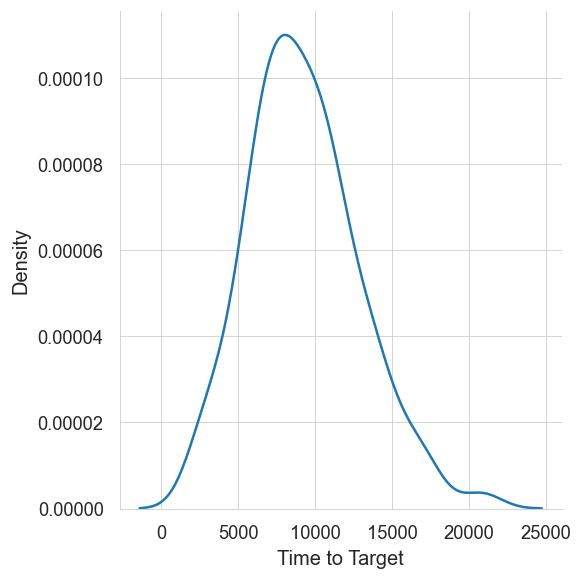

In [17]:
df_hits = data_agg[data_agg['Time to Target'] != -1]

s_w = stats.shapiro(data_agg["Time to Target"])

if s_w.pvalue <= 0.05:
    print("Time to target data does not come from a normal distribution (p = {:.3f}), perform ART in R instead".format(s_w.pvalue,))
    
    sns.displot(data_agg, x="Time to Target", kind="kde")
else:
    aov_ttt = pg.rm_anova(dv='Time to Target', within=['Condition', 'Task'], subject='P', data=df_hits)
    pg.print_table(aov_ttt)

    print("Remember to ignore comparisons if there is no significant effect!")
    ph_ttt = pg.pairwise_ttests(dv='Time to Target', within=['Condition', 'Task'], subject='P', marginal=True, effsize="cohen", data=df_hits)
    pg.print_table(ph_ttt)

## Error distance

Error distance data does not come from a normal distribution (p = 0.000), perform ART in R instead


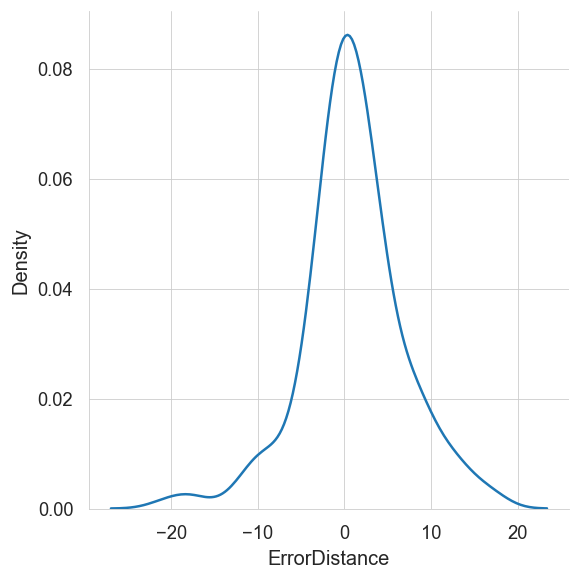

In [18]:
s_w = stats.shapiro(data_agg["AbsErrorDistance"])

if s_w.pvalue <= 0.05:
    print("Error distance data does not come from a normal distribution (p = {:.3f}), perform ART in R instead".format(s_w.pvalue,))
    
    sns.displot(data_agg, x="ErrorDistance", kind="kde")
else:
    aov_ed = pg.rm_anova(dv='AbsErrorDistance', within=['Condition', 'Task'], subject='P', data=data_agg)
    pg.print_table(aov_ed)

    print("Remember to ignore comparisons if there is no significant effect!")
    ph_ed = pg.pairwise_ttests(dv='AbsErrorDistance', within=['Condition', 'Task'], subject='P', marginal=True, effsize="cohen", data=data_agg)
    pg.print_table(ph_ed)

Task success rate data does not come from a normal distribution (p = 0.000), perform ART in R instead


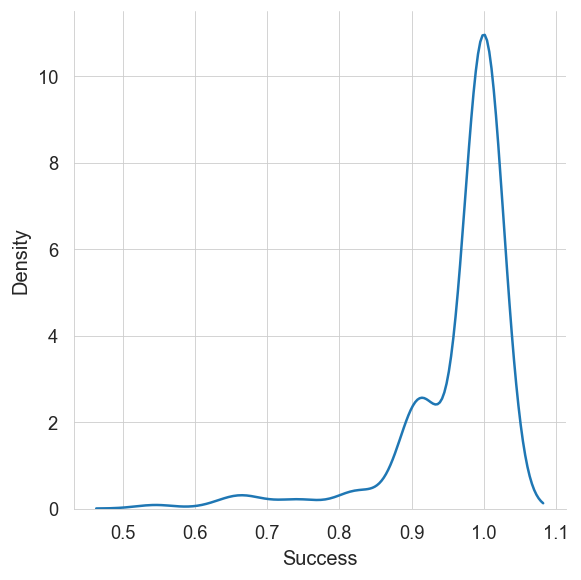

In [19]:
s_w = stats.shapiro(data_agg["Success"])

if s_w.pvalue <= 0.05:
    print("Task success rate data does not come from a normal distribution (p = {:.3f}), perform ART in R instead".format(s_w.pvalue,))
    
    sns.displot(data_agg, x="Success", kind="kde")
else:
    aov_success = pg.rm_anova(dv='Success', within=['Condition', 'Task'], subject='P', data=data_agg)
    pg.print_table(aov_success)

    print("Remember to ignore comparisons if there is no significant effect!")
    ph_success = pg.pairwise_ttests(dv='Success', within=['Condition', 'Task'], subject='P', marginal=True, effsize="cohen", data=data_agg)
    pg.print_table(ph_success)